In [1]:
import tensorflow as tf

from keras import backend as K

Using TensorFlow backend.


In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.utils import Sequence
from keras.optimizers import Adam, SGD, RMSprop

from keras import regularizers
from keras.layers import Input, Dropout, Flatten, AveragePooling2D

from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from utils.tla import triplet_loss
from utils import res_utils

In [3]:
n = 5
input_shape = (32, 32, 3)
margin = 0.3
batch_size = 128

stack_1 = res_utils.resnet_stack(0, 16, n, input_shape)
stack_1.load_weights("saved_weights/stack_1.h5")

stack_2 = res_utils.resnet_stack(1, 32, n, stack_1.output_shape[1:])
stack_2.load_weights("saved_weights/stack_2.h5")

stack_3 = res_utils.resnet_stack(2, 64, n, stack_2.output_shape[1:])
stack_3.load_weights("saved_weights/stack_3.h5")

top = res_utils.network_end(stack_3.output_shape[1:])
top.load_weights("saved_weights/model_top.h5")

In [6]:
input_a = Input(shape=input_shape)

# ----------------- Stack 1 -----------------------

processed_a = stack_1(input_a)
    
# ----------------- Stack 2----------------------------

processed_a = stack_2(processed_a)

# ----------------- Stack 3 ----------------------------

processed_a = stack_3(processed_a)

# ----------------- Top --------------------------------

trip_out = AveragePooling2D(pool_size=8)(processed_a)
trip_out = Flatten()(trip_out)

cat_1 = top(processed_a)

model = Model(input_a, [cat_1, trip_out])

In [7]:
def keras_triplet_loss(y_true, y_pred):
    return K.mean(triplet_loss(y_true, y_pred, margin=0.03))

In [8]:
model.compile(loss=['categorical_crossentropy', keras_triplet_loss],
              loss_weights = [1.0, 4.0],
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])

# Define Adv Model

In [9]:
adv_model = Model(input_a, cat_1)

adv_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

# Load Data

In [10]:
from keras.datasets import cifar10
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Set up Adv

In [11]:
import psutil

def restrict_cpu():
    p = psutil.Process()

    for i in p.threads():
        temp = psutil.Process(i.id)

        temp.cpu_affinity([i for i in range(8)])

In [12]:
from art.classifiers import KerasClassifier
from art.attacks.evasion.projected_gradient_descent import ProjectedGradientDescent


art_model = KerasClassifier(clip_values=(0., 1.), model=adv_model, use_logits=False)
#attack = ProjectedGradientDescent(art_model, norm=2, eps=3, eps_step=0.6, max_iter=6, batch_size=16)
attack = ProjectedGradientDescent(art_model, norm=np.inf, eps=8/255., eps_step=2/255., max_iter=7, batch_size=16)


adv_test = attack.generate(x_test[:20])

restrict_cpu()

In [12]:
print(adv_model.evaluate(x_test[:1000], y_test[:1000], verbose=0))

x_test_adv = attack.generate(x_test[:1000])

print(adv_model.evaluate(x_test_adv, y_test[:1000], verbose=0))

[0.4370940148830414, 0.9210000038146973]
[39.828236328125, 0.054999999701976776]


# Setting up training

In [13]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X, Y, batch_size=32):
        'Initialization'
        self.x = X
        self.y = Y
        self.anc_idxs = np.arange(len(X))
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        
        a_indexes = self.anc_idxs[index*self.batch_size:(index+1)*self.batch_size]

        x, y = self.__data_generation(a_indexes)

        return x, y

    def on_epoch_end(self):
        np.random.shuffle(self.anc_idxs)

    def __data_generation(self, a_idx):

        anchor = attack.generate(self.x[a_idx])
        positive = self.x[a_idx]

        X = np.concatenate((anchor, positive), axis=0)

        y_1 = self.y[a_idx]
        y_2 = self.y[a_idx]
        
        y_soft = np.concatenate((y_1, y_2), axis=0)
        
        y_triplet = np.argmax(y_soft, axis=-1)
        y_triplet = np.expand_dims(y_triplet, axis=-1)
        
        Y = [y_soft, y_triplet]

        return X, Y

In [14]:
train_generator = DataGenerator(x_train, y_train, batch_size=batch_size)
valid_generator = DataGenerator(x_test, y_test, batch_size=batch_size)

In [15]:
batch = train_generator.__getitem__(2)

loss = model.evaluate(batch[0], batch[1], batch_size=batch_size * 2)

[print(i) for i in zip(model.metrics_names, loss)]

256/256 [==============================] - 2s 6ms/step
('loss', 21.501413345336914)
('model_4_loss', 20.10817527770996)
('flatten_2_loss', 0.30803659558296204)
('model_4_acc', 0.5)
('flatten_2_acc', 0.00390625)


[None, None, None, None, None]

In [16]:
trip_model = Model(input_a, trip_out)

trip_preds = trip_model.predict(batch[0])

print("Verifying model loss:\n")
print(K.mean(triplet_loss(batch[1][1], trip_preds, margin=0.03)).numpy())

Verifying model loss:

0.30803657


In [1]:
 Hyper parameters
evaluate_every = 75 # interval for evaluating on one-shot tasks
n_iter = 2_500 # No. of training iterations
n_iteration = 0

loss_list = []

base_acc = []
soft_loss = []
trip_loss_1 = []

print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

for i in range(1, n_iter+1):
    
    batch = train_generator.__getitem__(n_iteration % train_generator.__len__())
    
    loss = model.train_on_batch(batch[0], batch[1])
    
    base_acc.append(loss[3])
    soft_loss.append(loss[1])
    trip_loss_1.append(loss[2])
    
    n_iteration += 1
        
    if i % 4000 == 0:
        K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr)/2.0)
    
    if i % train_generator.__len__() == 0:
        train_generator.on_epoch_end()
    
    if i % evaluate_every == 0:
        
        ploss = (np.mean(base_acc), np.mean(soft_loss), np.mean(trip_loss_1))
        
        loss_list.append(ploss)
        base_acc = []
        soft_loss = []
        trip_loss_1 = []
        
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,ploss,n_iteration))

In [18]:
print(adv_model.evaluate(x_test[:1000], y_test[:1000], verbose=0))

x_test_adv = attack.generate(x_test[:1000])

print(adv_model.evaluate(x_test_adv, y_test[:1000], verbose=0))

[0.839710036277771, 0.7639999985694885]
[1.762487349510193, 0.36899998784065247]


In [95]:
from utils.tla import _get_label_mask
from sklearn.metrics.pairwise import cosine_similarity

# get negatives mask
flat_labels = tf.squeeze(batch[1][1])
label_mask = 2 * tf.cast(_get_label_mask(flat_labels), tf.float32)

masked_dot_product = tf.add(dot_product, label_mask)

# get negative distances
neg_dists = tf.reduce_min(masked_dot_product, axis=1).numpy()

In [96]:
p_dists = tf.linalg.diag_part(dot_product).numpy()

print("Pos dists: ", p_dists.mean().round(4), p_dists.std())
print("Neg dists: ", neg_dists.mean().round(4), neg_dists.std())

Pos dists:  0.0567 0.03361584
Neg dists:  0.3677 0.10953977


Label: 7   Confidence: 0.8706218


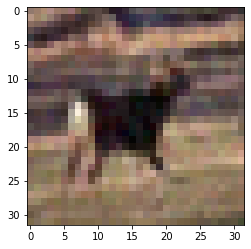

Label: 4   Confidence: 0.61823916


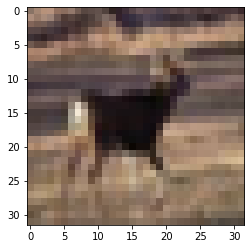

Distance: [[0.06191278]]


In [99]:
idx = 0
adv_pred = model.predict(batch[0][idx:idx+1])
print("Label:", adv_pred[0].argmax(), "  Confidence:", adv_pred[0].max())
plt.imshow(batch[0][idx])
plt.show()

clean_pred = model.predict(batch[0][idx+128:idx+129])
print("Label:", clean_pred[0].argmax(), "  Confidence:", clean_pred[0].max())
plt.imshow(batch[0][idx+128])
plt.show()

print("Distance:", 1 - cosine_similarity(adv_pred[1], clean_pred[1]))